In [1]:
from bib import *
import numpy as np
import pandas as pd
import sklearn.linear_model as sklin
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook

In [2]:
xtrains,ytrains,xvals,yvals,xtest,ytest=split(('CHL 1','THERM 1','SSH','SR','WS'),
                                               ['CHL '+ str(i) for i in range(2,19)])
ytrains,yvals,ytest=applyToy(lambda x:np.log(x)/np.log(10),ytrains,yvals,ytest)

In [3]:
def validate(model,xtrains,ytrains,xvals,yvals):
    fold_evaluation=[]
    for xt,yt,xv,yv in zip(xtrains,ytrains,xvals,yvals):
        model.fit(xt,yt)
        yp = model.predict(xv)
        yp = np.exp(yp*np.log(10))
        yv = np.exp(yv*np.log(10))
        fold_evaluation.append(evaluate(yp,yv))
        #print(evaluate(yp,yv))
    return np.mean(fold_evaluation),np.std(fold_evaluation)

# Random Forest

## Modèle par défaut

In [5]:
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook

### default Random Forest 
model = RandomForestRegressor(n_jobs=-1)
rmse = []

for i in tqdm_notebook(range(100)):
    r, s = validate(model,xtrains,ytrains,xvals,yvals)
    rmse.append(r)
    
print(np.mean(rmse), np.std(rmse))
#0.061387969533024424 0.0006388799625011037

KeyboardInterrupt: 

(0.06143450379131965, 0.019122104883837983)


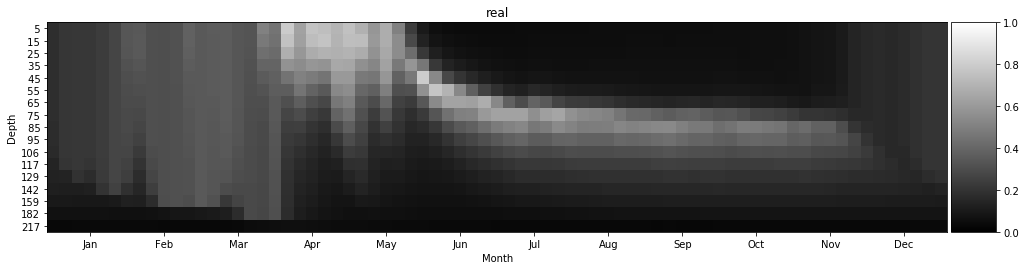

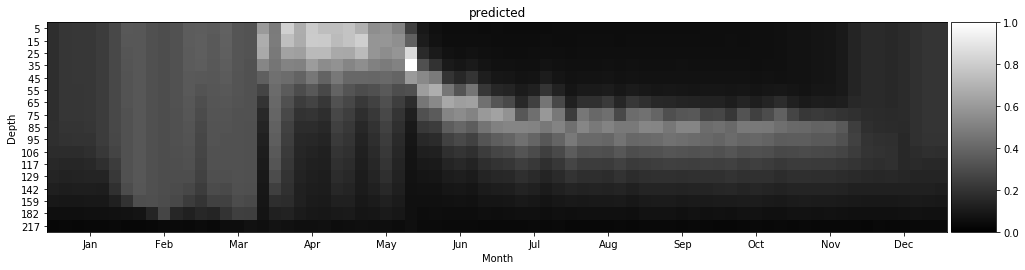

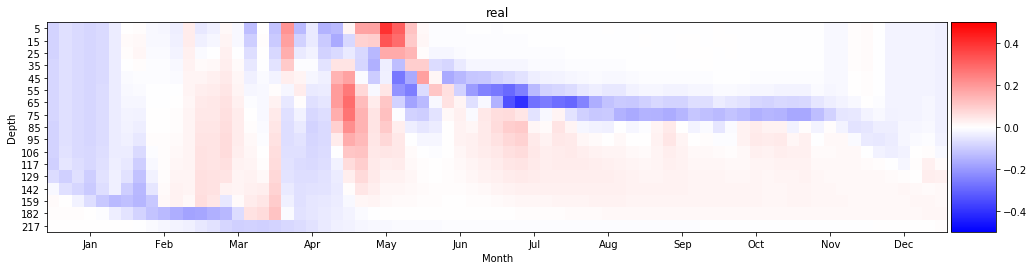

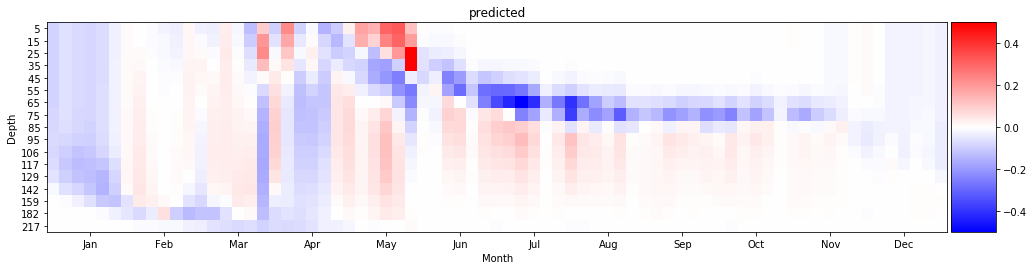

In [10]:
print(validate(model,xtrains,ytrains,xvals,yvals ))

yp = model.predict(xtest)
plotYear(np.exp(ytest*np.log(10)),title='real')
plotYear(np.exp(yp*np.log(10)),title='predicted')
climato(np.exp(ytest*np.log(10)).values, title='real')
climato(np.exp(yp*np.log(10)), title='predicted')

Le modèle est significativement plus performant que les précédents. Les discontinuités temporelles sont moins évidentes, et les prédictions sont plus proches des valeurs réelles. Cet estimateur, comme les autres, a surtout difficulté pour prédire les valeurs le plus grandes, qui sont aussi plus rares, et a donc tendance à sous-estimer.

## Importance des variables

In [ ]:
model.feature_importances_

La variable avec la plus grande importance est la température de surface, suivie de la chlorophylle de surface et la radiation solaire. Les varaibles présentant moins d'importance selon ce modèle sont la vitesse du vent et l'altitude de la mer.

## Modèle par défaut+convolution

In [4]:
### Modèle par défaut+conv

conv = [0.240694, 0.518612, 0.240694]

#[0.125, 0.75,0.125] (0.05898607601830889, 0.020658152459009323)
#[0.27901, 0.44198, 0.27901] (0.061781000015825094, 0.019202052377764817) gaussien sigma=1

def validate(model,xtrains,ytrains,xvals,yvals):
    fold_evaluation=[]
    for xt,yt,xv,yv in zip(xtrains,ytrains,xvals,yvals):
        model.fit(xt,yt)
        yp = model.predict(xv)
        for i in range(17):
            yp[:,i] = np.convolve(yp[:,i], conv, 'same')
        #yp = np.convolve(np.reshape(yp, 73*17), [1, 1,0], 'same')
        #yp = np.reshape(yp, ( 73,17))
        yp = np.exp(yp*np.log(10))
        yv = np.exp(yv*np.log(10))
        fold_evaluation.append(evaluate(yp,yv))
        print(evaluate(yp,yv))
    return np.mean(fold_evaluation),np.std(fold_evaluation)

model = RandomForestRegressor()
#model.fit(xtrains[0].values, ytrains[0].values)

0.05918532382781469
0.05919787336959346
0.05502885104039332
0.11541585050471122
0.10508308296119244
0.07095972920606759
0.05237811057288797
0.06792972709216813
0.04700297919038691
0.04710795208727331
0.04265457881570956
0.06107500256334064
0.04374329180479289
0.04635878076484452
0.05917510099672143
0.05408102567143921
(0.06164857877933358, 0.02007836145632788)


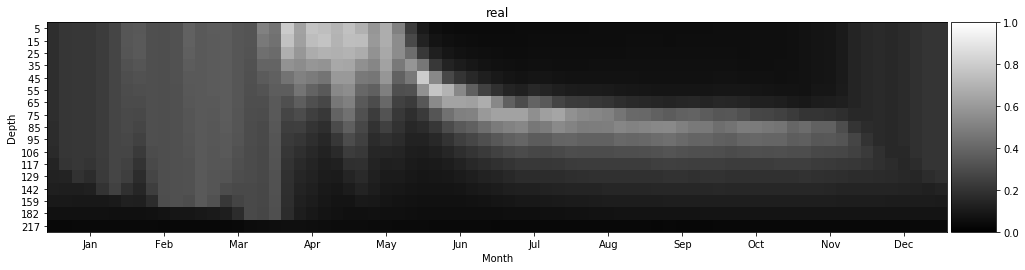

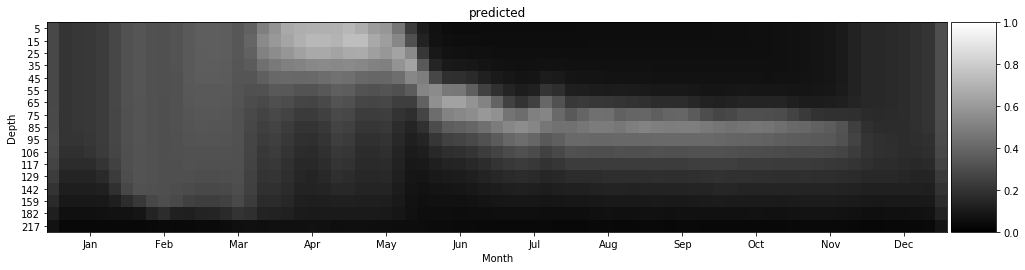

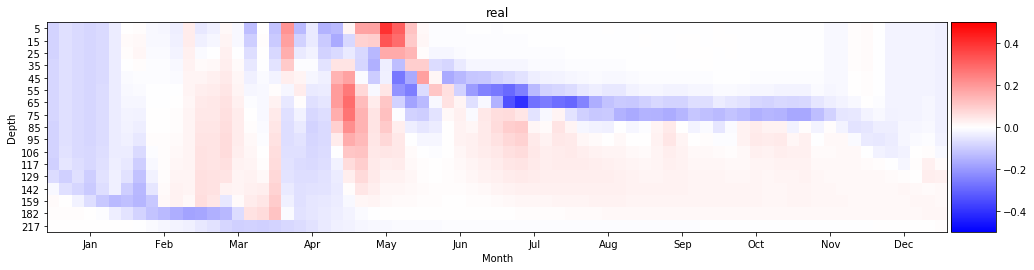

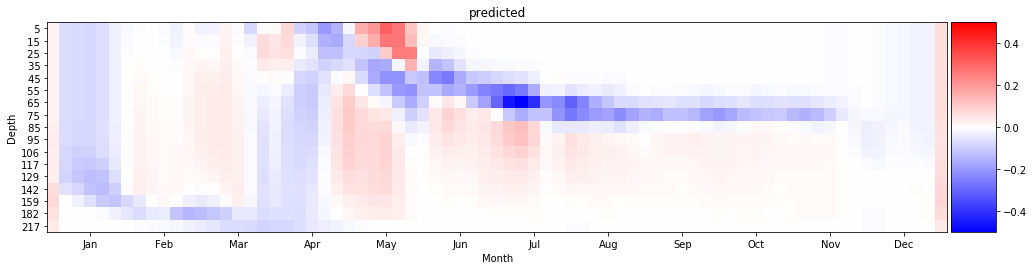

In [5]:
print(validate(model,xtrains,ytrains,xvals,yvals ))
model.fit(xtrains[0].values, ytrains[0].values)
yp = model.predict(xtest)
for i in range(17):
    yp[:,i] = np.convolve(yp[:,i], conv, 'same')
plotYear(np.exp(ytest*np.log(10)),title='real')
plotYear(np.exp(yp*np.log(10)),title='predicted')
climato(np.exp(ytest*np.log(10)).values, title='real')
climato(np.exp(yp*np.log(10)), title='predicted')

0.05458675266671143
0.06155199722728924
0.05627781836640862
0.11861978854586039
0.10343328845580062
0.0664076388050415
0.04629194634697434
0.061753990699457015
0.0467254810099669
0.045607081669027126
0.04116609371187641
0.0605766685407966
0.04264624393681615
0.04707206752934646
0.05194305022834324
0.04817797539860836
(0.059552367696145275, 0.02092921449478104)


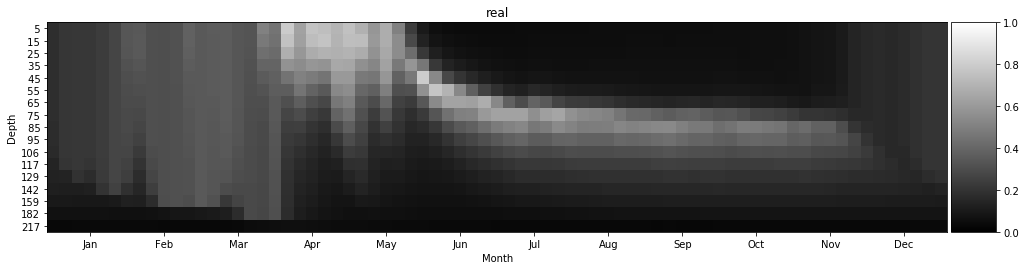

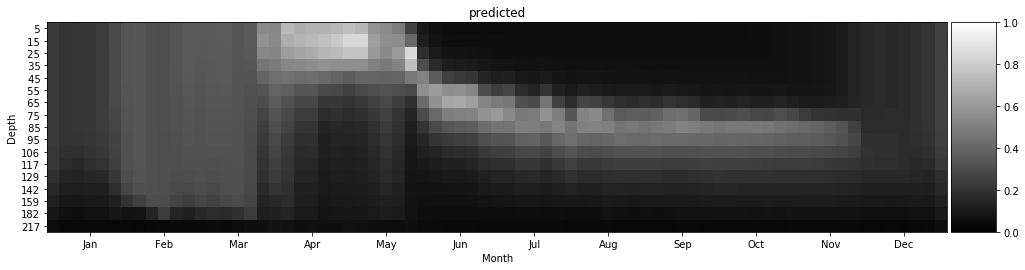

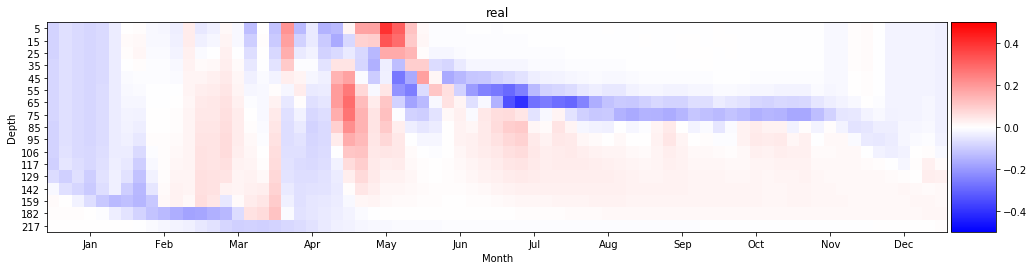

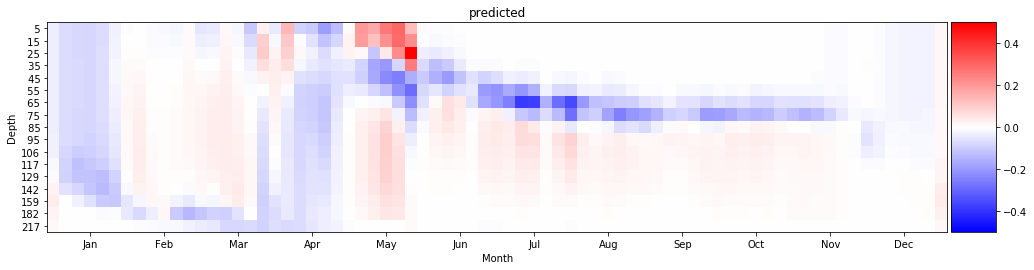

In [21]:
from scipy import signal

conv = [0.240694, 0.518612, 0.240694]

def validate_fft(model,xtrains,ytrains,xvals,yvals):
    fold_evaluation=[]
    for xt,yt,xv,yv in zip(xtrains,ytrains,xvals,yvals):
        model.fit(xt,yt)
        yp = model.predict(xv)
        for i in range(17):
            yp[:,i] = signal.fftconvolve(yp[:,i], conv, mode='same')
        #yp = signal.fftconvolve(yp, conv, mode='same')
        
        #yp = np.convolve(np.reshape(yp, 73*17), [1, 1,0], 'same')
        #yp = np.reshape(yp, ( 73,17))
        yp = np.exp(yp*np.log(10))
        yv = np.exp(yv*np.log(10))
        fold_evaluation.append(evaluate(yp,yv))
        print(evaluate(yp,yv))
    return np.mean(fold_evaluation),np.std(fold_evaluation)

model = RandomForestRegressor()

print(validate_fft(model,xtrains,ytrains,xvals,yvals ))
model.fit(xtrains[0].values, ytrains[0].values)
yp = model.predict(xtest)
for i in range(17):
    yp[:,i] = signal.fftconvolve(yp[:,i], conv, mode='same')

plotYear(np.exp(ytest*np.log(10)),title='real')
plotYear(np.exp(yp*np.log(10)),title='predicted')
climato(np.exp(ytest*np.log(10)).values, title='real')
climato(np.exp(yp*np.log(10)), title='predicted')


## Réseau convolutif

## Réglage des hyperparamètres

In [ ]:
# Fichier rf_cv.py
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook
from sklearn.multioutput import MultiOutputRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf}

import itertools

keys = grid.keys()
values = (grid[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
print(len(combinations))

In [ ]:
def validate(params,xtrains,ytrains,xvals,yvals):
    fold_evaluation=[]
    first= True
    for xt,yt,xv,yv in zip(xtrains,ytrains,xvals,yvals):
        

    
        model=RandomForestRegressor(n_estimators=params['n_estimators'], min_samples_split=params['min_samples_split'], 
                                    min_samples_leaf=params['min_samples_leaf'], 
                                    max_features=params['max_features'], bootstrap=True)
        multioutputregressor = MultiOutputRegressor(model,n_jobs=-1).fit(xt.values,yt.values)
        yp=multioutputregressor.predict(xv)
        #check error in original space
        yp = np.exp(yp*np.log(10))
        yv = np.exp(yv*np.log(10))
        fold_evaluation.append(evaluate(yp,yv))
        if first:
            print(evaluate(yp,yv))
            first=False
        
    return np.mean(fold_evaluation),np.std(fold_evaluation)

In [ ]:
min_err = 1000
min_std = 0
min_params = {}

for params in tqdm_notebook(combinations):
    print(params)
    error, std=validate(params,xtrains,ytrains,xvals,yvals)
    print('\t error: %.5f +- %.5f' % (error,std))
    
    if error < min_err:
        min_params = params
        min_err = error
        min_std = std

{'n_estimators': 10, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 1}
0.06087700770782778
	 error: 0.06249 +- 0.01843
     
{'n_estimators': 10, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 2}
0.06006894295866055
	 error: 0.06141 +- 0.01864
     
{'n_estimators': 10, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 4}
0.059659951905230435
	 error: 0.06083 +- 0.01927
     
{'n_estimators': 10, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 1}
0.06058189337759392
	 error: 0.06208 +- 0.01858
     
{'n_estimators': 10, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 2}
0.06046815365353734
	 error: 0.06132 +- 0.01863
     
{'n_estimators': 10, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 4}
0.059659951905230435
	 error: 0.06083 +- 0.01927
     
{'n_estimators': 10, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 1}
0.059897878989825216
	 error: 0.06129 +- 0.01890
     
{'n_estimators': 10, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 2}
0.05947015289339846
	 error: 0.06058 +- 0.01917
     
{'n_estimators': 10, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 4}
0.0585027719524435
	 error: 0.06059 +- 0.01936
     
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1}
0.06054542290788443
	 error: 0.06221 +- 0.01866
     
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 2}
0.05953601781788438
	 error: 0.06103 +- 0.01986
     
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 4}
0.06221706990227265
	 error: 0.06110 +- 0.01936
     
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 1}
0.06088675713842969
	 error: 0.06166 +- 0.01894
     
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 2}
0.06023645068197685
	 error: 0.06152 +- 0.01937
     
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 4}
0.06221706990227265
	 error: 0.06110 +- 0.01936
     
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 1}
0.058180708563894686
	 error: 0.06100 +- 0.01943
     
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 2}
0.058927836157816806
	 error: 0.06049 +- 0.01954
     
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 4}
0.059108930209354545
	 error: 0.06070 +- 0.01940
     
{'n_estimators': 120, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 1}
0.0577455606328606
	 error: 0.05957 +- 0.01918
     
{'n_estimators': 120, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 2}
0.05742316474021334
	 error: 0.05944 +- 0.01927
     
{'n_estimators': 120, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 4}
0.05650287084188237
	 error: 0.05899 +- 0.01945
     
{'n_estimators': 120, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 1}
0.057401423626907214
	 error: 0.05942 +- 0.01925
     
{'n_estimators': 120, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 2}
0.05727845384691211
	 error: 0.05938 +- 0.01931
     
{'n_estimators': 120, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 4}
0.05650287084188237
	 error: 0.05899 +- 0.01945
     
{'n_estimators': 120, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 1}
0.05652940441175658
	 error: 0.05916 +- 0.01937
     
{'n_estimators': 120, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 2}
0.05695233726031927
	 error: 0.05911 +- 0.01940
     
{'n_estimators': 120, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 4}
0.05622335758958305
	 error: 0.05894 +- 0.01950
     
{'n_estimators': 120, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1}
0.057576697460784726
	 error: 0.05929 +- 0.01984
     
{'n_estimators': 120, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 2}
0.057556027636831354
	 error: 0.05918 +- 0.01983
     
{'n_estimators': 120, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 4}
0.05816808531108929
	 error: 0.05904 +- 0.02004
     
{'n_estimators': 120, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 1}
0.05780811491986887
	 error: 0.05894 +- 0.01992
     
{'n_estimators': 120, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 2}
0.05850010092213194
	 error: 0.05935 +- 0.02002
     
{'n_estimators': 120, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 4}
0.05816808531108929
	 error: 0.05904 +- 0.02004
     
{'n_estimators': 120, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 1}
0.05825129743526042
	 error: 0.05909 +- 0.01999
     
{'n_estimators': 120, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 2}
0.05766222095240275
	 error: 0.05908 +- 0.01996
     
{'n_estimators': 120, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 4}
0.05758342483583115
	 error: 0.05915 +- 0.02016
     
{'n_estimators': 230, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 1}
0.057795937291650785
